# Project 1 - Cat or Dogs ?

Authors: Selim Ben Abdallah, Paola De Truchis, Eduardo De Jesus Zancanaro Garcia et Edda Iveland

The goal of this project is to study, classify and segment the images in the `Oxford-IIIT Pet` dataset. This dataset contains images and lables of cats and dogs of 37 different races. 
We will start by loading the data, then perform an exploratory analysis. 

# 0 - Data/Libs

In [54]:
# Standard library
import os
import random

# Scientific / data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T

# Scikit-learn
from sklearn.model_selection import train_test_split


In [55]:
PATH_TO_TRAINVAL_TXT = "dataset/annotations/trainval.txt"
PATH_TO_TEST_TXT = "dataset/annotations/test.txt"
PATH_TO_LIST_TXT = "dataset/annotations/list.txt"

PATH_TO_IMG = "dataset/images/" # .jpg
PATH_TO_TRIMAPS = "dataset/annotations/trimaps/" #.png

- 37 category pet dataset with roughly 200 images for each class
- Images have a large variations in scale, pose and lighting.
- All images have an associated ground truth annotation of breed, head ROI, and pixel level trimap segmentation.

# 1 - Data analysis

### Species distribution

In [ ]:
# List all species names + type + number

pet_dict = {}

with open(PATH_TO_LIST_TXT, 'r') as f:
    for _ in range(6):
        next(f) #to skip the 6 first lines in list.txt

    for line in f:
        line = line.strip()
        if not line:
            continue #to skip empty lines if any

        class_id, id_, species, breed_id = line.split() #to retrieve the info from each line
        specie_name = "_".join(class_id.split("_")[:-1]) #to get the specie name only

        pet_dict[class_id] = {
            "class_id": class_id, # e.g. Abyssinian_100
            "id": int(id_), # 1:37 Class ids
            "species": int(species), # 1:Cat 2:Dog
            "breed_id": int(breed_id), # 1-25:Cat 1:12:Dog
            "species_name": specie_name, # e.g. Abyssinian (without _100)
        }

In [57]:
df = pd.DataFrame.from_dict(pet_dict, orient="index")
df["species_label"] = df["species"].map({1: "Cat", 2: "Dog"})
df["img_path"] = df["class_id"].apply(lambda x: f"{PATH_TO_IMG}{x}.jpg")
df["trimap_path"] = df["class_id"].apply(lambda x: f"{PATH_TO_TRIMAPS}{x}.png")
df.head()

class_id  id  species  breed_id species_name  \
Abyssinian_100  Abyssinian_100   1        1         1   Abyssinian   
Abyssinian_101  Abyssinian_101   1        1         1   Abyssinian   
Abyssinian_102  Abyssinian_102   1        1         1   Abyssinian   
Abyssinian_103  Abyssinian_103   1        1         1   Abyssinian   
Abyssinian_104  Abyssinian_104   1        1         1   Abyssinian   

               species_label                           img_path  \
Abyssinian_100           Cat  dataset/images/Abyssinian_100.jpg   
Abyssinian_101           Cat  dataset/images/Abyssinian_101.jpg   
Abyssinian_102           Cat  dataset/images/Abyssinian_102.jpg   
Abyssinian_103           Cat  dataset/images/Abyssinian_103.jpg   
Abyssinian_104           Cat  dataset/images/Abyssinian_104.jpg   

                                                   trimap_path  
Abyssinian_100  dataset/annotations/trimaps/Abyssinian_100.png  
Abyssinian_101  dataset/annotations/trimaps/Abyssinian_101.png  
Abyssinian_102  dataset/annotations/trimaps/Abyssinian_102.png  
Abyssinian_103  dataset/annotations/trimaps/Abyssinian_103.png  
Abyssinian_104  dataset/annotations/trimaps/Abyssinian_104.png

In [58]:
df["species_label"].value_counts()

species_label
Dog    4978
Cat    2371
Name: count, dtype: int64

<Axes: ylabel='count'>

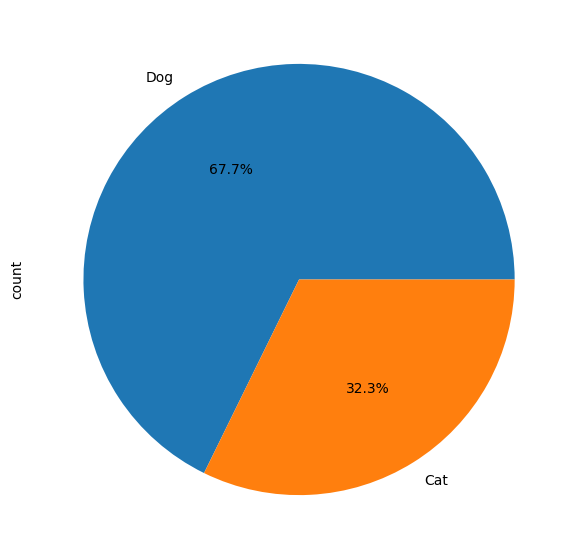

In [59]:
df["species_label"].value_counts().plot(kind="pie", autopct="%1.1f%%", figsize=(7,7))

We see that there are more photos of dogs compared to cats in the database. There are  68% images of dogs and 32% images of cats. 

<Axes: title={'center': 'Number of Pets per Species'}, xlabel='species_name'>

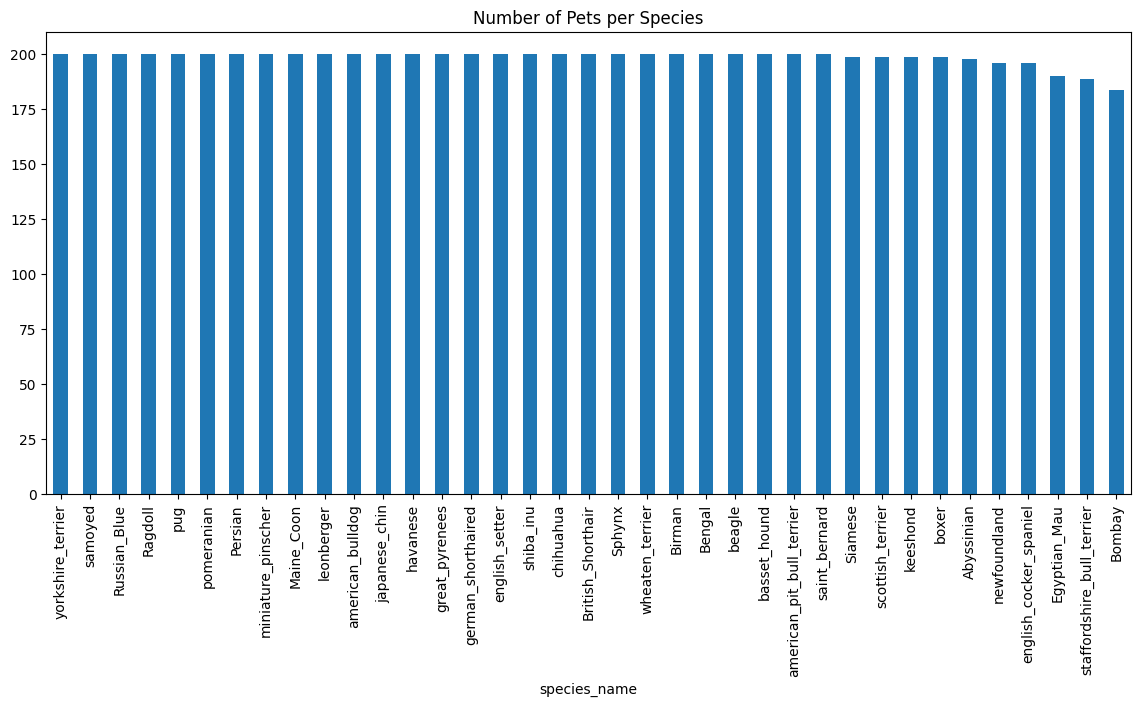

In [134]:
df["species_name"].value_counts().plot(kind="bar", figsize=(14,6), rot=90, title="Number of Pets per Species")

<Axes: title={'center': 'Cat Species Distribution'}, ylabel='count'>

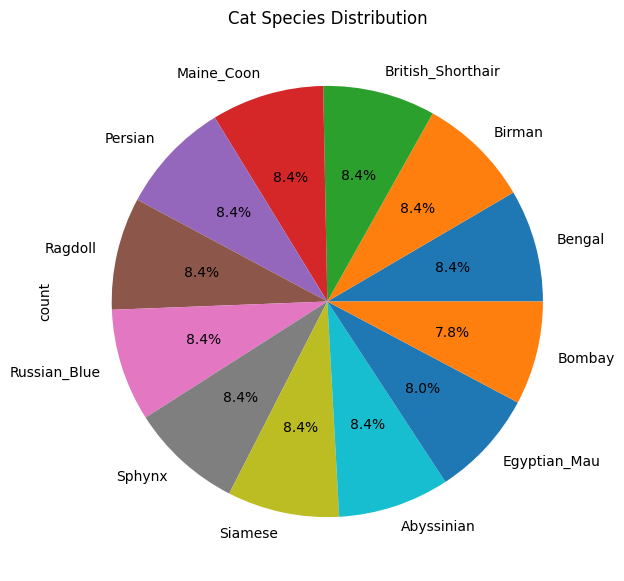

In [ ]:
df[df["species"] == 1]["specie_name"].value_counts().plot(
    kind="pie", autopct="%1.1f%%", figsize=(7,7), title="Cat Species Distribution"
)


<Axes: title={'center': 'Dog Species Distribution'}, ylabel='count'>

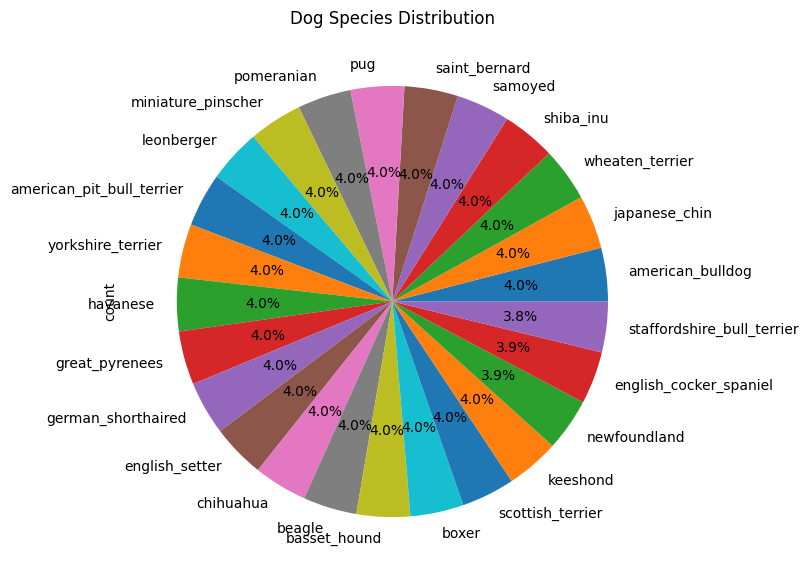

In [62]:
df[df["species"] == 2]["species_name"].value_counts().plot(
    kind="pie", autopct="%1.1f%%", figsize=(7,7), title="Dog Species Distribution"
)


------

All races have 200 images each, except for :

Cats: 
 - Siameses with 199 images
 - Abyssinians with 198 images
 - Egyptian_Maus with 190 images
 - Bombays with 184 images
 
Dogs: 
 - boxers with 199 images
 - keeshonds with 199 images
 - scottish_terriers with 199 images
 - english_cocker_spaniels with 196 images
 - newfoundlands with 196 images
- staffordshire_bull_terriers with 189 images

### Image and Masks

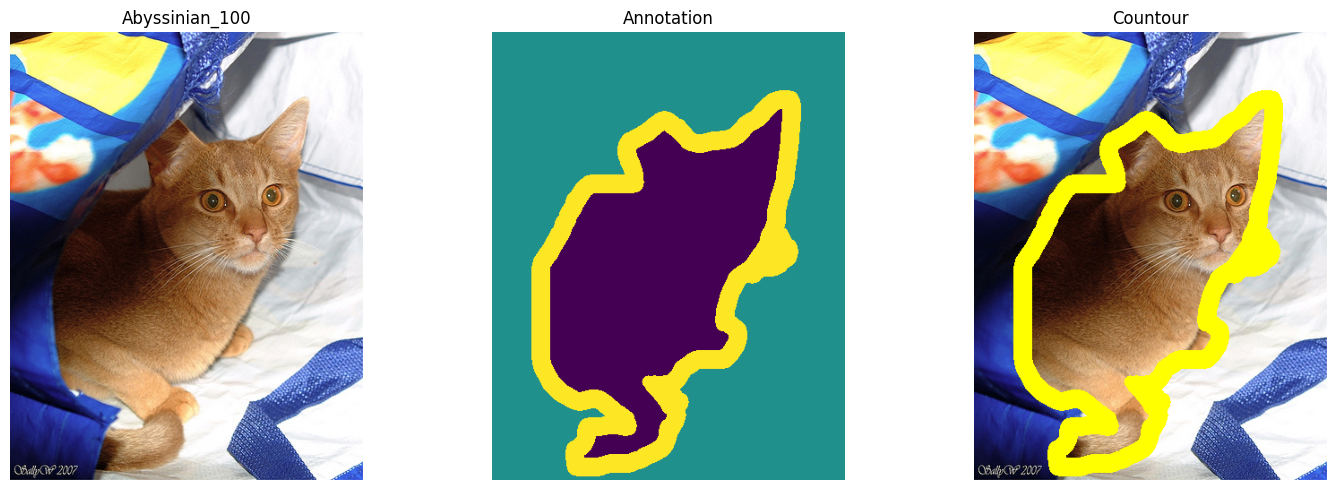

In [63]:
def show_image_annotation(class_id):
    row = df.loc[class_id] if class_id in df.index else df[df["class_id"] == class_id].iloc[0]

    img = Image.open(row["img_path"]).convert("RGB")
    ann = Image.open(row["trimap_path"])

    img_arr = np.array(img)
    ann_arr = np.array(ann)

    if img.size == ann_arr.size:
        print("the mask and image have the same size")

    overlay = img_arr.copy()
    overlay[ann_arr == 3] = [255, 255, 0]

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(img)
    ax[0].set_title(row["class_id"])
    ax[0].axis("off")

    ax[1].imshow(ann_arr, cmap="viridis")
    ax[1].set_title("Annotation")
    ax[1].axis("off")

    ax[2].imshow(overlay)
    ax[2].set_title("Countour")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

show_image_annotation("Abyssinian_100")

In [64]:
def check_image_mask(df):
    missing_masks = []
    size_mismatch = []

    for idx, row in df.iterrows():
        img_path = row["img_path"]
        mask_path = row["trimap_path"]

        if not os.path.exists(mask_path):
            missing_masks.append((row["class_id"], mask_path))
            continue 
        
        img = Image.open(img_path)
        mask = Image.open(mask_path)

        if img.size != mask.size:
            size_mismatch.append((row["class_id"], img.size, mask.size))

    print("Image/Mask Check")
    print(f"Total samples: {len(df)}")
    print(f"Missing masks: {len(missing_masks)}")
    print(f"Size mismatches: {len(size_mismatch)}")
    print()

    if missing_masks:
        print("Missing masks:")
        for cid, path in missing_masks[:10]:
            print(f"  - {cid}: {path}")
        if len(missing_masks) > 10:
            print(f"  ... and {len(missing_masks) - 10} more.")
        print()

    if size_mismatch:
        print("Size mismatches (image vs mask):")
        for cid, img_size, mask_size in size_mismatch[:10]:
            print(f"  - {cid}: image={img_size}, mask={mask_size}")
        if len(size_mismatch) > 10:
            print(f"  ... and {len(size_mismatch) - 10} more.")

check_image_mask(df)


Image/Mask Check
Total samples: 7349
Missing masks: 0
Size mismatches: 0



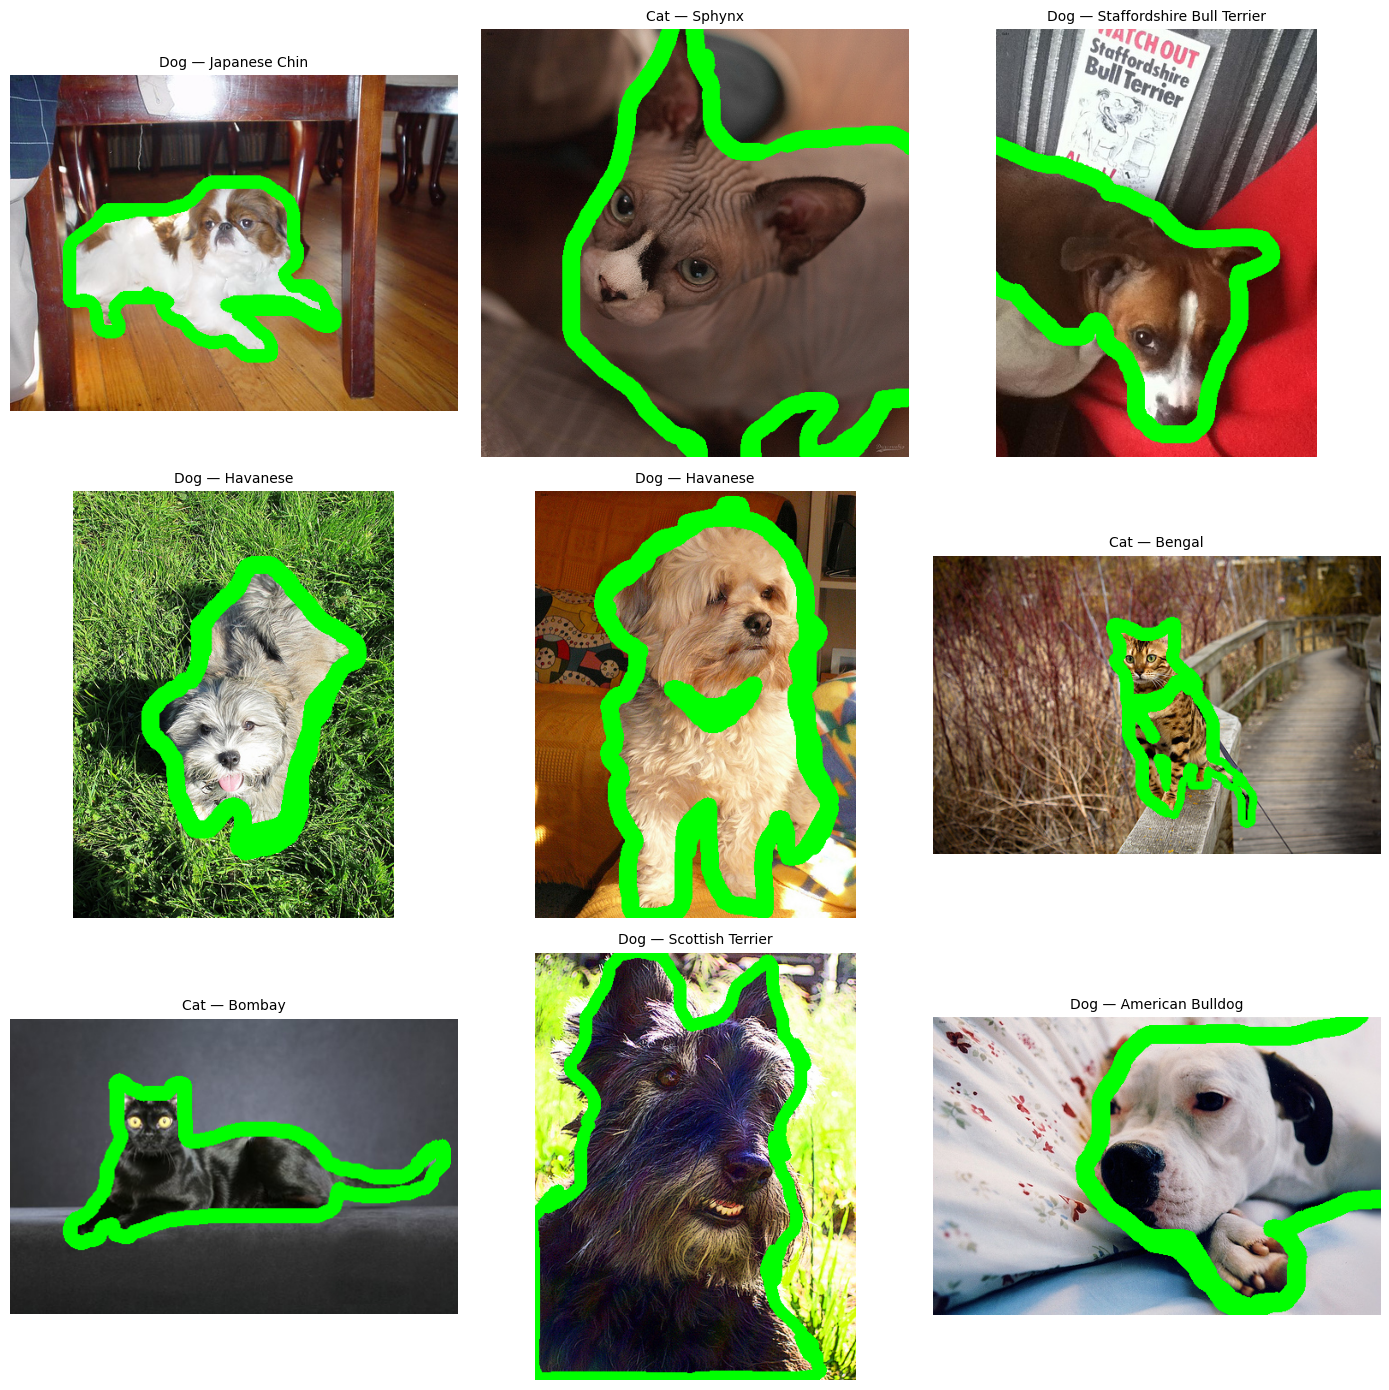

In [67]:
# Showing masking of random images

# Filter out MacOS ghost files
mask_files = [
    f for f in os.listdir(PATH_TO_TRIMAPS)
    if f.endswith(".png") and not f.startswith("._")
]

# Choose 9 random mask files
sample_masks = random.sample(mask_files, 9)

plt.figure(figsize=(14, 14))

for i, mask_file in enumerate(sample_masks, 1):
    
    # matching image filename
    img_file = mask_file.replace(".png", ".jpg")

    # --- Load image and mask ---
    img = Image.open(os.path.join(PATH_TO_IMG, img_file))
    mask = Image.open(os.path.join(PATH_TO_TRIMAPS, mask_file))

    img_arr = np.array(img)
    mask_arr = np.array(mask)

    # Overlay 
    overlay = img_arr.copy()
    overlay[mask_arr == 3] = [0, 255, 0]    # green outline

    # Extract metadata from dataframe 
    # remove ".jpg" for merging with df's image column
    image_id = img_file.replace(".jpg", "")
    
    row = df[df["class_id"] == image_id].iloc[0]
    
    species = row["species_label"].capitalize()       # Cat / Dog
    breed = row["species_name"].replace("_", " ").title()   # Pretty formatting

    title = f"{species} — {breed}"

    # --- Plot ---
    plt.subplot(3, 3, i)
    plt.imshow(overlay)
    plt.title(title, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

From studying the image masks, we have observed that the masking is done very well. No masks are missing and there is no mask and image mismatch. When drawing random images from the database, we see that the masking includes details such as collars, toys and objects that interfere with the animal. 

In [68]:
def add_image_sizes(df):
    widths = []
    heights = []

    for path in df["img_path"]:
        img = Image.open(path)
        w, h = img.size
        widths.append(w)
        heights.append(h)

    df["width"] = widths
    df["height"] = heights

add_image_sizes(df)

In [69]:
df[["width", "height"]].describe()

width       height
count  7349.000000  7349.000000
mean    437.237447   391.387264
std     115.775876   109.394560
min     114.000000   103.000000
25%     337.000000   333.000000
50%     500.000000   375.000000
75%     500.000000   500.000000
max    3264.000000  2606.000000

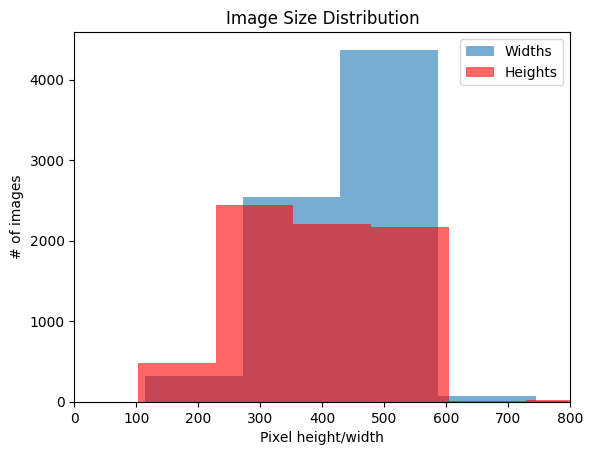

In [70]:
plt.hist(df["width"], bins=20, label= "Widths", alpha= 0.6)
plt.hist(df["height"], bins=20, color = "red", label = "Heights", alpha= 0.6)
plt.title("Image Size Distribution")
plt.xlabel("Pixel height/width")
plt.ylabel("# of images")
plt.legend()
plt.xlim(0, 800)
plt.show()

<Axes: title={'center': 'Width vs Height'}, xlabel='width', ylabel='height'>

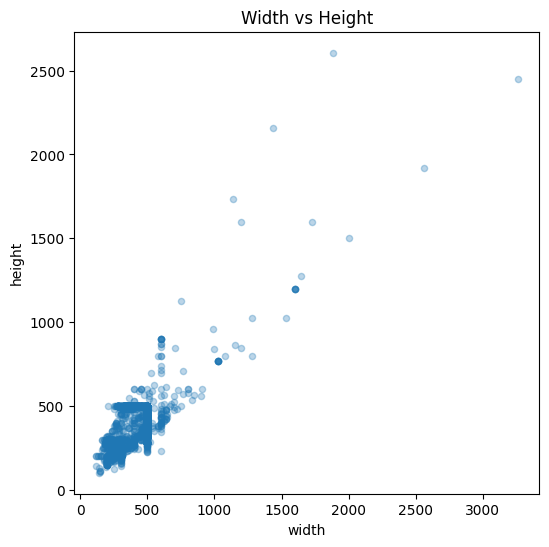

In [71]:
df.plot.scatter(x="width", y="height", alpha=0.3, figsize=(6,6), title="Width vs Height")

In [72]:
df.groupby(["width", "height"]).size().sort_values(ascending=False).head(20)

width  height
500    375       1424
       333       1069
375    500        511
333    500        509
300    225        261
500    334        250
       332        185
334    500        151
500    335         97
332    500         91
500    500         88
335    500         53
225    300         49
500    400         39
       281         29
       330         28
       376         27
400    500         27
500    374         27
357    500         26
dtype: int64

We observe that the size of the images vary significantly. We will have to normalise the image size before training our models in the next sections. 

We will now study bias of the images. Perhaps some breeds are more often photographed outside rather than inside. There could possibly be more background compared to foreground from some breeds as well. The lightning of the images could also differ from breed to breed or between dogs and cats. For this reason, we will study: 
- The average colour of the images per species and breed
- The average green intensity per species and breed
- The foreground ratio per species and breed

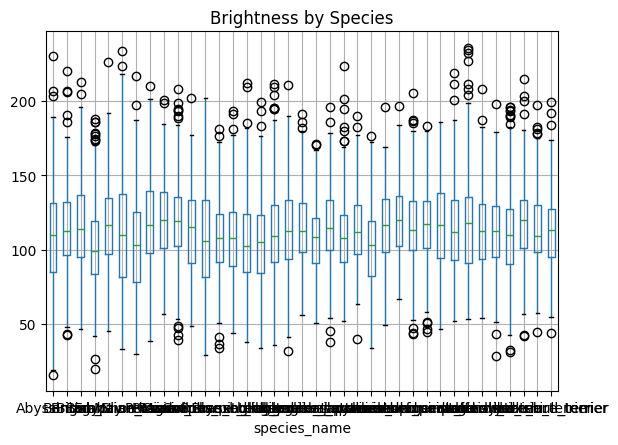

In [ ]:
df["avg_brightness"] = df["class_id"].apply(lambda name:
    np.array(Image.open(f"dataset/images/{name}.jpg")).mean()
)

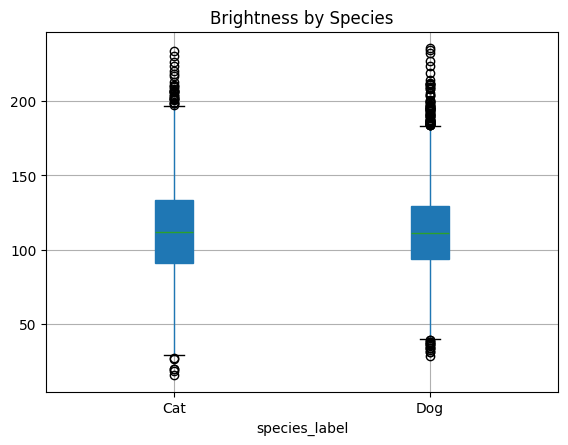

In [81]:
order_label = df.groupby("species_label")["avg_brightness"].median().sort_values(ascending=False).index

df.boxplot(column="avg_brightness", by="species_label", patch_artist=True, positions=range(len(order_label)))
plt.title("Brightness by Species")
plt.suptitle("")
plt.show()

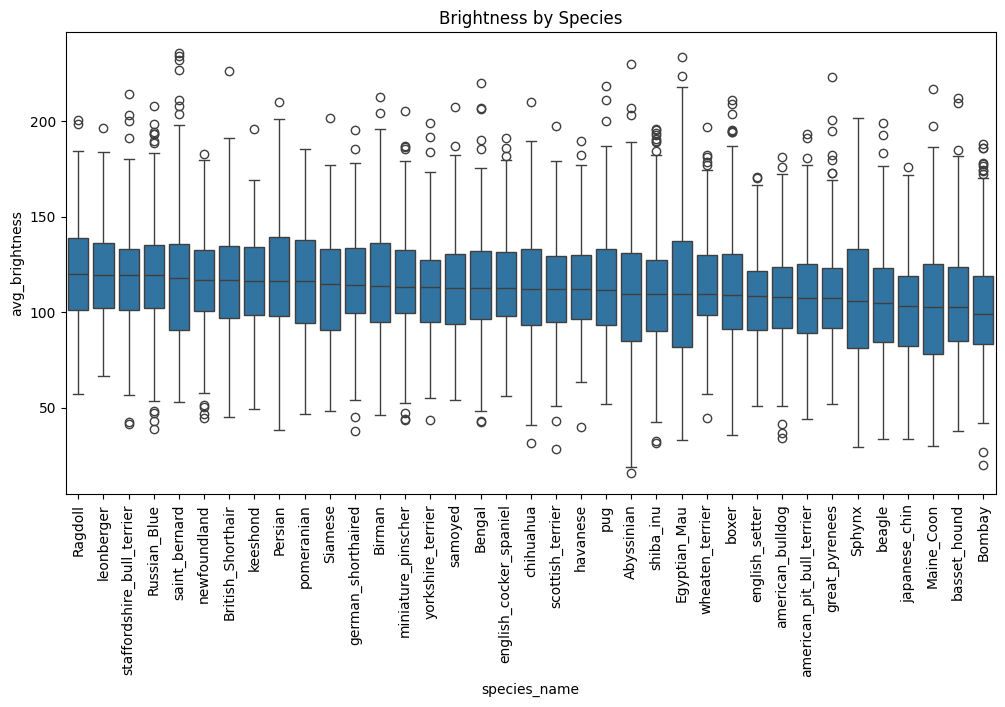

In [ ]:
order_name = (
    df.groupby("species_name")["avg_brightness"].median().sort_values(ascending=False).index
)

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    x="species_name",
    y="avg_brightness",
    order=order_name
)

plt.title("Brightness by Species")
plt.xticks(rotation=90)
plt.show()

In [89]:
def average_green_level(image_name):
    img_path = f"{PATH_TO_IMG}/{image_name}.jpg"
    img = np.array(Image.open(img_path))
    return img[:, :, 1].mean()     # channel 1 = green

In [91]:
df["avg_green"] = df["class_id"].apply(average_green_level)

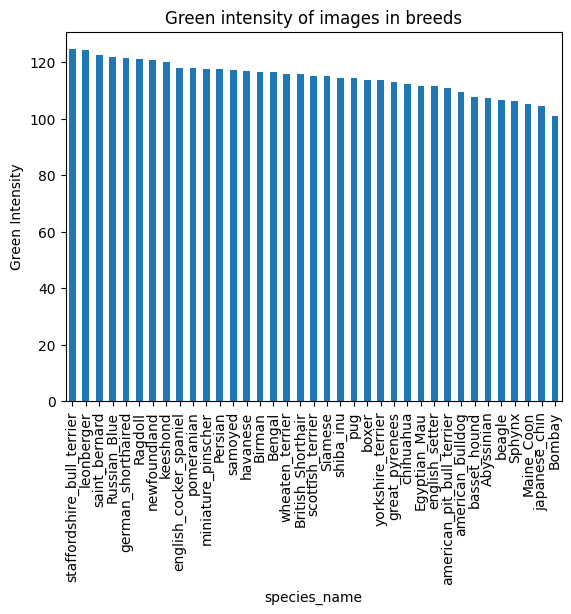

In [95]:
df.groupby("species_name")["avg_green"].mean().nlargest(37).plot(kind="bar")
plt.title("Green intensity of images in breeds")
plt.ylabel("Green Intensity")
plt.show()

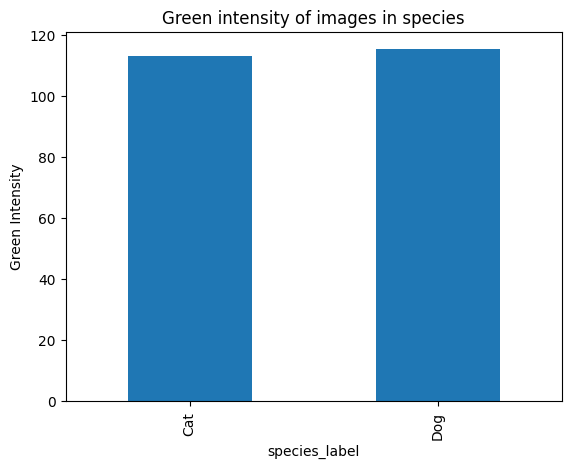

In [96]:
df.groupby("species_label")["avg_green"].mean().plot(kind="bar")
plt.title("Green intensity of images in species")
plt.ylabel("Green Intensity")
plt.show()

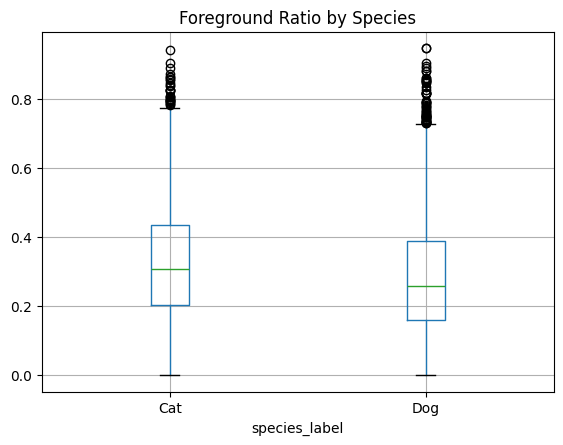

In [98]:
#Foreground Ratio to explore segmentation mask bias

foreground_ratios = []

for _, row in df.iterrows():
    mask_file = f"{row['class_id']}.png"
    mask = np.array(Image.open(f"{PATH_TO_TRIMAPS}/{mask_file}"))
    fg_ratio = (mask == 1).mean()
    foreground_ratios.append(fg_ratio)

df["fg_ratio"] = foreground_ratios

df.boxplot(column="fg_ratio", by="species_label")
plt.title("Foreground Ratio by Species")
plt.suptitle("")
plt.show()

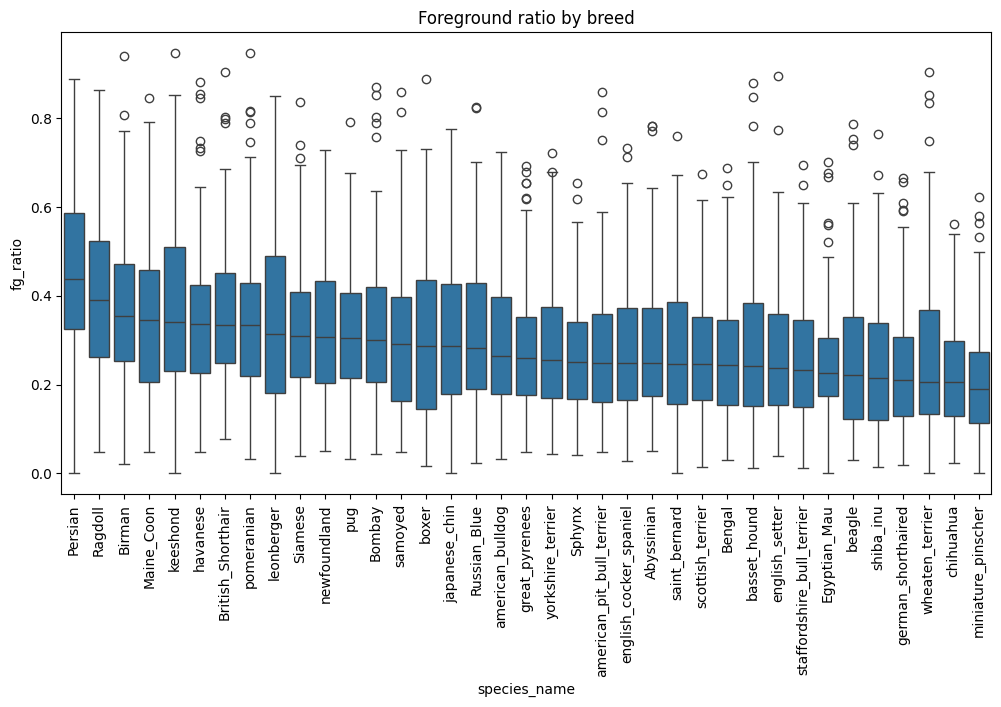

In [99]:
order_name = (
    df.groupby("species_name")["fg_ratio"].median().sort_values(ascending=False).index
)

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    x="species_name",
    y="fg_ratio",
    order=order_name
)

plt.title("Foreground ratio by breed")
plt.xticks(rotation=90)
plt.show()

Overall comments on first part. 
Because of this, we will normalise the images by size and colour. We will keep the observed biases in mind when analysing the final results. 

### TrainVal / Test Datasets

In [100]:
def load_split_file(path, img_root, mask_root):
    rows = []

    with open(path, "r") as f:
        for line in f:
            parts = line.strip().split()

            class_id = parts[0]           # Abyssinian_100
            id_      = int(parts[1])      # 1–37 (class id)
            species  = int(parts[2])      # 1=cat, 2=dog
            breed_id = int(parts[3])      # 1–25 cat, 1–12 dog
            specie_name = "_".join(class_id.split("_")[:-1])

            rows.append({
                "class_id": class_id,
                "id": id_,
                "species": species,
                "breed_id": breed_id,
                "specie_name": specie_name,
                "img_path": f"{img_root}/{class_id}.jpg",
                "trimap_path": f"{mask_root}/{class_id}.png",
            })

    return pd.DataFrame(rows)


In [101]:
trainval_df = load_split_file(
    "dataset/annotations/trainval.txt",
    img_root="dataset/images",
    mask_root="dataset/annotations/trimaps"
)

test_df = load_split_file(
    "dataset/annotations/test.txt",
    img_root="dataset/images",
    mask_root="dataset/annotations/trimaps"
)

# Binary label
trainval_df["label"] = trainval_df["species"].map({1: 0, 2: 1})  # 0=cat, 1=dog
test_df["label"] = test_df["species"].map({1: 0, 2: 1})


In [102]:
# Train / Val Separation

train_df, val_df = train_test_split(
    trainval_df,
    test_size=0.2,
    stratify=trainval_df["label"],
    random_state=42,
)

In [111]:
## Data transformations
pixel_size = (128,128)
mean_RGB = [0.485, 0.456, 0.406]
std_rgb = [0.229, 0.224, 0.225]
train_transform = T.Compose([
    T.Resize(pixel_size),
    T.RandomHorizontalFlip(p=0.5), #basic augm 
    T.ToTensor(),
    T.Normalize(mean = mean_RGB,
                std = std_rgb),
])

val_transform = T.Compose([
    T.Resize(pixel_size),
    T.ToTensor(),
    T.Normalize(mean = mean_RGB,
                std = std_rgb),
])

### Custom Dataset : Dataframe <-> DataLoader

In [112]:
class PetsClassificationDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img = Image.open(row["img_path"]).convert("RGB")
        label = int(row["label"])  # 0=cat, 1=dog

        if self.transform:
            img = self.transform(img)

        return img, label

### DataLoader

In [113]:
train_ds = PetsClassificationDataset(train_df, transform=train_transform)
val_ds   = PetsClassificationDataset(val_df,   transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0)

In [114]:
print("Train size:", len(train_df))
print("Val size:", len(val_df))

Train size: 2944
Val size: 736


### CNN (Simple Version)

In [115]:
class CNN_V1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)  # binary classif

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 64×64
        x = self.pool(F.relu(self.conv2(x)))  # 32×32
        x = self.pool(F.relu(self.conv3(x)))  # 16×16

        x = x.view(x.size(0), -1)             
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x



In [116]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}") # mps is for macs with Apple Silicon

model = CNN_V1().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

Using device: cpu


In [117]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for imgs, labels in tqdm(loader, desc="Training", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Validating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total




In [ ]:
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

for epoch in range(50):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.3f} | "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.3f}")


In [ ]:
def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy")
    plt.legend()

    plt.show()

plot_history(history)

In [164]:
def predict_image(model, img_path, transform, device="cpu"):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(tensor)
        pred = logits.argmax(dim=1).item()

    return pred, img

In [ ]:
label_map = {0: "Cat", 1: "Dog"}

def show_test_predictions(model, test_df, transform, label_map, num_samples=5, device="cpu"):
    samples = test_df.sample(num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(5 * num_samples, 5))

    if num_samples == 1:
        axes = [axes]

    for ax, (_, row) in zip(axes, samples.iterrows()):
        pred, img = predict_image(model, row["img_path"], transform, device)
        pred_label = label_map[pred]
        true_label = label_map[row["label"]]

        ax.imshow(img)
        ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}")
        ax.axis("off")

    plt.show()

show_test_predictions(model, test_df, val_transform,label_map=label_map num_samples=4, device=device)


- Data augmentation 
- More complex CNN (pretrained models ?)
- Confmat
- Save model weights
- 37-breeds classification
- Right evaluation metrics
- segmentation( U-Net, DeepLab etc)

## 3. Classification fine : reconnaître la race de chaque animal parmi les 37 catégories disponibles.

In [152]:
# Multiclass label
trainval_df["label"] = trainval_df["id"] -1  # 1=Abyssinian, etc..
test_df["label"] = test_df["id"] -1

In [153]:
train_df_3, val_df_3 = train_test_split(
    trainval_df,
    test_size=0.2,
    stratify=trainval_df["label"],
    random_state=42,
)

In [154]:
train_ds_3 = PetsClassificationDataset(train_df_3, transform=train_transform)
val_ds_3   = PetsClassificationDataset(val_df_3,   transform=val_transform)

train_loader_3 = DataLoader(train_ds_3, batch_size=32, shuffle=True,  num_workers=0)
val_loader_3   = DataLoader(val_ds_3,   batch_size=32, shuffle=False, num_workers=0)

In [ ]:
N_train = len(train_df_3)
N_test = len(val_df_3)
N_x_pixels = pixel_size[0]
N_y_pixels = pixel_size[1]
N_channels = len(std_rgb)
N_classes = train_df_3["label"].nunique()
N_dim_flatten = N_channels*N_x_pixels*N_y_pixels
print("Number of classes:",N_classes)
print("Size of input images (channels*pixels)", N_channels,"*",N_x_pixels,"*", N_y_pixels)
print("Train size:", N_train)
print("Val size:", N_test)

Number of classes: 37
Size of input images (channles*pixels) 3 * 128 * 128
Train size: 2944
Val size: 736


In [195]:
class ConvNet(nn.Module):
    def __init__(self, N_classes):
        super(ConvNet, self).__init__()
        # input shape: (batch, 3, 128, 128)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3) #, padding=1) # 3 input channels, 32 filters
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3) #, padding=1) # 32 input channels, 64 filters
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Pooling with 2x2 window
        self.dropout1 = nn.Dropout(0.25) # Dropout 25%
        self.dropout2 = nn.Dropout(0.5) # Dropout 50%
        self.fc1 = nn.Linear(64*62*62, 128)  # Fully connected layer
        self.fc2 = nn.Linear(128, N_classes) # Output layer for N_classes= 37
    
    def forward(self, x):
        x = F.relu(self.conv1(x))       # Conv + ReLU
       # x = self.pool(x)                # MaxPooling
        x = F.relu(self.conv2(x))       # Conv + ReLU
        x = self.pool(x)                # MaxPooling
        x = self.dropout1(x)            # Dropout 0.25
        x = torch.flatten(x, 1)         # Flatten from (B, C, H, W) -> (B, C*H*W)
        x = F.relu(self.fc1(x))         # Dense 128 + ReLU
        x = self.dropout2(x)            # Dropout 0.5
        x = self.fc2(x)                 # Output layer (raw logits)
        return x                        # logits; use CrossEntropyLoss

# Instantiate model
model_multiclass = ConvNet(N_classes).to(device)

In [196]:
criterion = nn.CrossEntropyLoss()          # combines LogSoftmax + NLLLoss
optimizer = torch.optim.Adadelta(model_multiclass.parameters())

In [197]:
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

for epoch in range(2):
    train_loss, train_acc = train_one_epoch(model_multiclass, train_loader_3, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model_multiclass, val_loader_3, criterion, device)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.3f} | "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.3f}")

KeyboardInterrupt: 

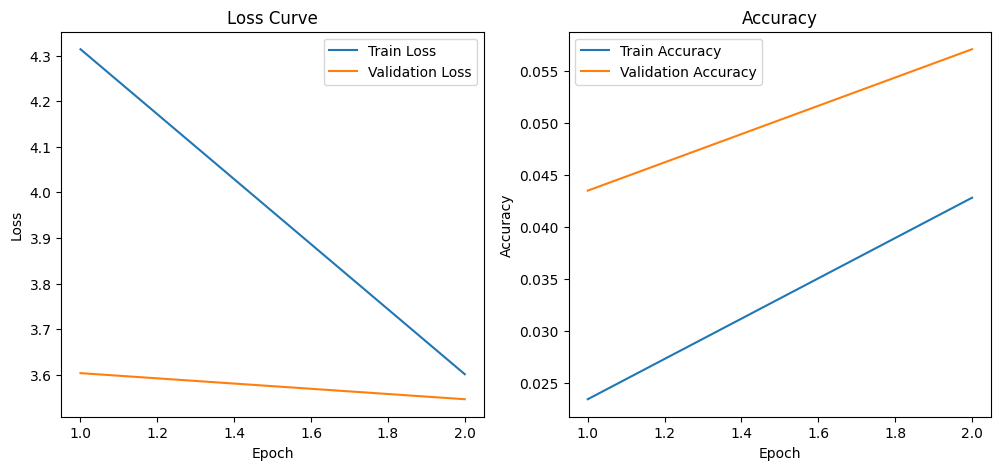

In [183]:
plot_history(history)

In [178]:
label_map = {
    0:  "Abyssinian",
    1:  "american_bulldog",
    2:  "american_pit_bull_terrier",
    3:  "basset_hound",
    4:  "beagle",
    5:  "Bengal",
    6:  "Birman",
    7:  "Bombay",
    8:  "boxer",
    9:  "British_Shorthair",
    10: "Chihuahua",
    11: "Egyptian_Mau",
    12: "english_cocker_spaniel",
    13: "english_setter",
    14: "german_shorthaired",
    15: "great_pyrenees",
    16: "havanese",
    17: "Japanese_Chin",
    18: "keeshond",
    19: "leonberger",
    20: "Maine_Coon",
    21: "miniature_pinscher",
    22: "newfoundland",
    23: "Persian",
    24: "pomeranian",
    25: "pug",
    26: "Ragdoll",
    27: "Russian_Blue",
    28: "saint_bernard",
    29: "samoyed",
    30: "scottish_terrier",
    31: "shiba_inu",
    32: "Siamese",
    33: "Sphynx",
    34: "staffordshire_bull_terrier",
    35: "wheaten_terrier",
    36: "yorkshire_terrier"
}


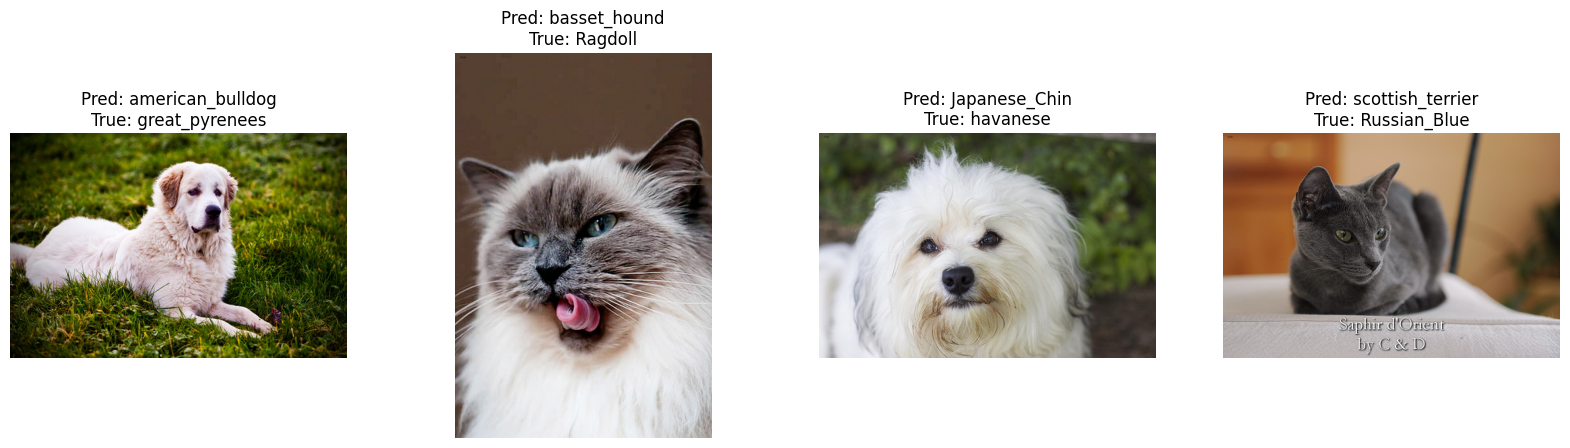

In [179]:
show_test_predictions(model_multiclass, test_df, val_transform, label_map=label_map, num_samples=4, device=device)

## 4. Segmentation with U-net

## 5. Comparative Analysis

### 5.1 Comparison of segmentation performance by race

### 5.1 Analysing behavioural(?) differences between cats and dogs

Conclustion on the fifth part. 

## Conclusion